In [162]:
#!/usr/bin/env conda run -n datimacchinaenv python
import sys
print(sys.executable)    ### C:\ProgramData\Anaconda3_1\envs\datimacchinaenv\python.exe

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
!jupyter kernelspec list

C:\ProgramData\Anaconda3_1\envs\datimacchinaenv\python.exe


Available kernels:
  python3    C:\ProgramData\Anaconda3_1\envs\datimacchinaenv\share\jupyter\kernels\python3


In [370]:
# !{sys.executable} -m pip install xlwt
# !{sys.executable} -m pip install openpyxl
# !{sys.executable} -m pip install Pillow
# !{sys.executable} -m pip install seaborn
# !conda install --yes --prefix {sys.prefix} xlrd 
# !{sys.executable} -m pip install tables     
# !{sys.executable} -m pip install simpledbf
import sys
import pandas as pd
pd.options.display.max_columns = None  ## in order to show all columns
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import IPython.display as IPdisplay
import shutil
# per matrice correlazione
import seaborn as sns
# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats
import matplotlib.tri as mtri
import datetime as dt
import h5py
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
import xlwt  # necessario per esportare xls con pandas
from matplotlib.mlab import griddata # create grid for contour plot  # pip3 install git+ssh://git@github.com:ustroetz/python-osrm.git

ImportError: cannot import name 'griddata' from 'matplotlib.mlab' (C:\ProgramData\Anaconda3_1\envs\datimacchinaenv\lib\site-packages\matplotlib\mlab.py)

In [272]:
import glob
from PIL import Image
from images2gif import writeGif  # requires --> (datimacchinaenv) pip install images2gif

#####   important before to start do the same change to the package images2gif   ###########

#       manually change the two import statements in your already installed package (in __init__.py):

#       -from images2gif import readGif as readGif
#       -from images2gif import writeGif as writeGif
#       +from .images2gif import readGif as readGif
#       +from .images2gif import writeGif as writeGif

### LOAD FILES

In [317]:
path = os.getcwd()+'\\DATA\\20200107'

files = []
filespath = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if r'MERGE' in file:
            files.append(file)
            filespath.append(os.path.join(r, file))
            
# since there is only one file I need only the file name
os.path.join(r, files[0])

print(files)
print(filespath)
df = pd.read_excel(os.path.join(r, files[0]))
print('file loaded'+files[0])
print('\nColumns list:')
print(df.columns.tolist())

['GEODATA_S-1048_RAW_20200107_MERGE.xls']
['C:\\Users\\fpe\\JUPYTER\\datimacchina\\DATA\\20200107\\GEODATA_S-1048_RAW_20200107_MERGE.xls']
file loadedGEODATA_S-1048_RAW_20200107_MERGE.xls

Columns list:
['Date', 'S-1048_ADVANCE_ADVANCE_NO [-]', 'Pressure excavation chamber 1 [bar]', 'Pressure excavation chamber 2 [bar]', 'Pressure excavation chamber 3 [bar]', 'Pressure excavation chamber 4 [bar]', 'Pressure excavation chamber 5 [bar]', 'Pressure excavation chamber 6 [bar]', 'Pressure excavation chamber 7 [bar]', 'Pressure excavation chamber 8 [bar]', 'Line 1 grout injection pressure [bar]', 'Line 1 grout injection flow [l/min]', 'Line 1 grout injection amount [l]', 'Line 2 grout injection pressure [bar]', 'Line 2 grout injection flow [l/min]', 'Line 2 grout injection amount [l]', 'Line 3 grout injection pressure [bar]', 'Line 3 grout injection flow [l/min]', 'Line 3 grout injection amount [l]', 'Line 4 grout injection pressure [bar]', 'Line 4 grout injection flow [l/min]', 'Line 4 grou

### CLEAN DATA AND CREATE NEW COLUMN

In [318]:
#### Drop double columns ending by .1

df.filter(regex='[.]1$')
df = df[df.columns.drop(list(df.filter(regex='[.]1$')))]

###  Create new columns

#### First we create a column that can be detected as date

df['datestamp']=pd.to_datetime(df.Date)
df['timestamp']=df.datestamp.apply(lambda x: int(time.mktime(x.timetuple())))

df.sort_values('timestamp',inplace=True)

#### Then we find the position of relevant indicators  --> do not remove spaces before this 

# cerco la posizione delle colonne principali
 
# regex  --> (?i) means case unsensible

pos_filllev=int(df.columns.get_loc(df.filter(regex='(?i)fill.*lev.*work.*chamb').columns.tolist()[0]))
pos_stroke=int(df.columns.get_loc(df.filter(regex='(?i)aet.*stroke').columns.tolist()[0]))
pos_p01=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.1)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_p02=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.2)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_p03=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.3)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_p04=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.4)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_p05=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.5)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_pos02=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)posit)(?=.*(?i)2)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_pos03=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)posit)(?=.*(?i)3)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_advspeed=int(df.columns.get_loc(df.filter(regex='(?i)Advance.*speed.*').columns.tolist()[0]))
pos_torque=int(df.columns.get_loc(df.filter(regex='(?i)torque.*cutting.*wheel.*').columns.tolist()[0]))
pos_feed=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)flow)(?=.*(?i)feed)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_slurry=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)slurry)(?=.*(?i)line)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_num=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)1048)(?=.*(?i)advance)(?=.*(?i)[-]).*$').columns.tolist()[0]))
pos_prch01=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)1)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch02=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)2)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch03=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)3)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch04=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)4)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch05=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)5)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch06=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)6)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch07=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)7)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch08=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)8)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_date=int(df.columns.get_loc(df.filter(regex='datestamp').columns.tolist()[0]))
pos_timestamp=int(df.columns.get_loc(df.filter(regex='timestamp').columns.tolist()[0]))
# densities
pos_dens_p04=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)dens)(?=.*(?i)p04)(?=.*(?i)t/m).*$').columns.tolist()[0]))
pos_dens_slurry=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)dens)(?=.*(?i)slurr)(?=.*(?i)line)(?=.*(?i)t/m³).*$').columns.tolist()[0]))
pos_dens_feed=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)dens)(?=.*(?i)feed)(?=.*(?i)line)(?=.*(?i)t/m³).*$').columns.tolist()[0]))
# stroke cyl abcde
pos_cy_a=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) A ).*$').columns.tolist()[0]))
pos_cy_b=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) B ).*$').columns.tolist()[0]))
pos_cy_c=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) C ).*$').columns.tolist()[0]))
pos_cy_d=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) D ).*$').columns.tolist()[0]))
pos_cy_e=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) E ).*$').columns.tolist()[0]))

col_list=df.columns.tolist()
cl = col_list.copy()  # per chiamare la lista in maniera veloce

## Creo colonne

- **'datestamp_diff'** delta t tra righe in ore  **dt_h** nomesemplificato
- **'stroke_diff[mm]'**  delta stroke corretto AET
- **'stroke_diff_a[mm]'**  delta stroke a,b,c,d,e per ogni pistone

- **'state1'** 1 se tutti i pistoni avanzano
- **'state2'** 1 se AET net stroke avanza

- **'state'** output 'fulloper','stall_rotating','stall_stand'

- **'dfxls['vol_teor_cum[m³]']'**
- **'dfxls['vol_teor_cum_dry[m³]']'**
- **'dfxls['dvol_teor[m³]']'**

- **'dfxls['dvol_calc[m³]']'**
- **'dfxls['dvol_calc_MthE[m³]']'**

- **'dfxls['dvol_teor-calc[m³]']'**   dvol_terico - dvol_calc


- **col_list**  is a list for fast detection of columns
- **pos_dict**  is a dictionary for fast detection of new created columns



In [319]:
# reinitialize the dataframe
dfxls = df.copy()


# Dati di input
nw = 0.25 # indice dei vuoti
rhosoil_ = 2.10 # t/m3 terreno in sito
rhow = 1
rhobent = 2.2
Area_Cutter = 39.59

## We create new columns

#### Datestamp diff (aa-mm-gg hh-mm-ss)
#### Datestamp diff [h]

dfxls['datestamp_p'] = dfxls.datestamp.shift(1).copy()
# Beign the first row == 0 we need to delete it _ but we will do it at the end otherwise we lose data
#dfxls=dfxls.dropna().copy()

dfxls['datestamp_diff']= dfxls['datestamp']-dfxls['datestamp_p']
# dfxls['datestamp_diff2'] = dfxls['datestamp'].diff(periods=1).copy()  # stesso risultato come sopra

dfxls['datestamp_diff[h]'] = dfxls['datestamp_diff'].astype('timedelta64[s]').fillna(0).copy()/3600
dfxls['dt_h'] = dfxls['datestamp_diff[h]'].copy()

#### Differenziali dpressure chambers loop sulle 8 celle di pressione

for i in np.arange(1,9,1):
    dfxls['dpress_ch{}'.format(i)] = dfxls[col_list[pos_prch01+i-1]].diff(periods=1).copy()

#### Creo colonna stroke - delta stroke solo positivi - volumi teorici e volumi teorici cumulati        ['dVol_Teor[m³]']

dfxls['stroke_diff[mm]'] = dfxls[col_list[pos_stroke]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_a[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_b[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_c[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_d[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_e[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()


# creazione indici di movimento
def ff(row):
    
    if row['stroke_diff[mm]']>0 and row['stroke_diff_a[mm]']>0 and row['stroke_diff_b[mm]']>0 and\
       row['stroke_diff_c[mm]']>0 and row['stroke_diff_d[mm]']>0\
       and row['stroke_diff_e[mm]']>0:
        return 1
    else:
        return 0

dfxls['state1'] = dfxls.apply(ff, axis=1)     # 0 se stop 1 se tutti i jack sono in movimento
dfxls['dstroke[mm]'] = dfxls['AET Net Stroke [mm]'].diff(periods=1).fillna(0)  ## identico a dfxls['stroke_diff[mm]']
dfxls['state2'] = dfxls['dstroke[mm]'].map(lambda x: 1 if x>0 else 0) # 1 se dstroke avanza 0 se fermo o negativo



#####  Volumi dallo stroke
    
dfxls['dstroke_pos[mm]'] =dfxls[col_list[pos_stroke]].diff(periods=1).fillna(0).map(lambda x: 0 if x<0 else x).copy()   #è il dstroke solo positivo


dfxls['nw'] = nw

dfxls['vol_teor_cum[m³]'] = dfxls.iloc[:,pos_stroke]/1000*Area_Cutter    # use only to calculate dvol
dfxls['vol_teor_cum_dry[m³]'] = dfxls['vol_teor_cum[m³]']*(1-dfxls.nw)         # use only to calculate dvol

dfxls['dvol_teor[m³]'] = dfxls['vol_teor_cum[m³]'].diff(periods=1).fillna(0).map(lambda x: 0 if x<0 else x).copy()
dfxls['dvol_teor_dry[m³]'] = dfxls['vol_teor_cum_dry[m³]'].diff(periods=1).fillna(0).map(lambda x: 0 if x<0 else x).copy()

#### Calcolo di volumi dal Slurry-Feed * dt           ['dVol_bal_feed_slurry[m³]']

# dfxls['feed_adj[m³/h]'] = dfxls[col_list[pos_feed]]-dfxls[col_list[pos_pos02]]-dfxls[col_list[pos_pos03]]  # incasina non togliere i sensori 2 e 3
# dfxls['bal_feed_slurry[m³/h]']=dfxls[col_list[pos_slurry]]-dfxls['feed_adj[m³/h]']

dfxls['bal_feed_slurry[m³/h]']=dfxls[col_list[pos_slurry]]-dfxls[col_list[pos_feed]]

dfxls['dvol_bal_feed_slurry[m³]']=dfxls['bal_feed_slurry[m³/h]']*dfxls['datestamp_diff[h]']
# dfxls['dvol_bal_feed_slurry_cum[m³]']=dfxls['dvol_bal_feed_slurry[m³]'].cumsum().shift(-1).fillna(0)



#### Calcolo di volumi dal Slurry-Feed * dt   METHOD E

dfxls['rhosoil'] = rhosoil_
dfxls['rho_insitu'] = (dfxls.rhosoil *(1-dfxls.nw))+(dfxls.nw*rhow)

dfxls['dvol_calc_MthE[m³]']=(
                            (dfxls[col_list[pos_slurry]]*
                            (dfxls[col_list[pos_dens_slurry]]-1)/(dfxls.rhosoil-1))-
                            (dfxls[col_list[pos_feed]]*
                            (dfxls[col_list[pos_dens_feed]]-1)/(dfxls.rhosoil-1))
                            )*dfxls['datestamp_diff[h]']



# dfxls['dvol_calc_MthE_cum[m³]']=dfxls['dvol_calc_MthE[m³]'].cumsum().shift(-1).fillna(0)


#### Calcolo volumi dal fill level con formula polinomiale     ['dvol_work_chamb[m³]']

def calcvolume(x):
    vol=-0.113*x**5+0.1236*x**4+0.5462*x**3-0.1059*x**2+5.6112*x+11.794
    if x > 0 : 
        return vol
    elif x < 0 : 
        return vol
    else :
        return 0
    
dfxls['instant_volume[m³]'] = dfxls[col_list[pos_filllev]].map(lambda x: calcvolume(x))
dfxls['dvol_work_chamb[m³]'] = dfxls['instant_volume[m³]'].diff(periods=1).fillna(0).copy()
# dfxls['dvol_work_chamb_cum[m³]'] = dfxls['dvol_work_chamb[m³]'].cumsum().shift(-1).fillna(0)

#### Calcolo i balance istantanei e totali

dfxls['dvol_calc[m³]'] = dfxls['dvol_work_chamb[m³]']+dfxls['dvol_bal_feed_slurry[m³]']

dfxls['dvol_teor-calc[m³]'] = dfxls['dvol_teor[m³]']-dfxls['dvol_calc[m³]']





#### Creo la colonna STATE (fulloper,stall_rotating,stall_stand)

dfxls['state']=0
f_min_torq25 = dfxls.iloc[:,pos_torque].describe()[4]
f_min_adv25 = dfxls.iloc[:,pos_advspeed].describe()[4]

dfxls.loc[(dfxls[col_list[pos_torque]]>0) & (dfxls[col_list[pos_advspeed]]>0),'state'] = 'fulloper'
dfxls.loc[(dfxls[col_list[pos_torque]]!=0) & (dfxls[col_list[pos_advspeed]]==0),'state'] = 'stall_rotating'
dfxls.loc[(dfxls[col_list[pos_torque]]==0) & (dfxls[col_list[pos_advspeed]]==0),'state'] = 'stall_stand'

### CREATE col_list for fast individuation of columns

col_list=dfxls.columns.tolist()


### creo pos_dict per le colonne nuove

ls0 = []
ls1 = []

for i in col_list[111:]:
    
    ls0.append('pos_{}'.format(i.replace(" ",'').split("[")[0]))
    ls1.append(dfxls.columns.get_loc(i))
    
pos_dict = dict(zip(ls0,ls1))   

### Modifiche aggiuntive
- Correggo cambio concio colonna 'num_corr'
- Creo colonna **'change'** False-True quando passo da:
    - fermo( **'dstroke[mm]'** <=0 , **'state2'** =0)
    - in movimento( **'dstroke[mm]'** >0 , **'state2'** =1)
- Creo colonna **change** ovvero quando la macchina si ferma fz state2
- Crea colonna **change2** ovvero quando la macchina riparte fz state2
- Creo colonna **state3** basata su inizio fine processo
- Creo colonna **num_corr** che è il numero di concio corretto
- Creo colonna **'dstroke_pos[mm]'** e **'dstroke_pos_cum_seg[mm]'**
  per tenere conto del solo stroke di avanzamento per concio
- Calcolo i volumi cumulati:
    - **'dvol_teor_cum_seg[m³]'**
    - **'dvol_bal_feed_slurry_cum_seg[m³]'**
    - **'dvol_work_chamb_cum_seg[m³]'**
    - **'dvol_calc_cum_seg[m³]'**
    - **'dvol_teor-calc_cum_seg[m³]'**
    - **'dvol_calc_MthE_cum_seg[m³]'**
    - **theormass1** **theormass2**

In [320]:
# creo colonna 'num_corr' 

dfxls.reset_index(drop=True)
for index, row in dfxls.iterrows():
    if index==0: numconcio = dfxls.iloc[0,pos_num]
    dfxls.loc[index,'num_corr'] = numconcio
    if index > 1 and row['dstroke[mm]']==0 and rowp['dstroke[mm]']>0 and row[col_list[pos_stroke]]>1500:
        numconcio += 1
        dfxls.loc[index,'num_corr'] = numconcio
    rowp = row


# creo colonna change in base a 'state2'

dfxls['change'] = dfxls['state2'].gt(dfxls['state2'].shift())
dfxls['change2'] = dfxls['state2'].shift().gt(dfxls['state2'])

dic_start = dfxls[dfxls['change']==True].groupby(col_list[pos_num]).agg({col_list[pos_timestamp]:min}).to_dict()
dic_start = dic_start[list(dic_start.keys())[0]]

dic_end = dfxls[dfxls['change2']==True].groupby(col_list[pos_num]).agg({col_list[pos_timestamp]:max}).to_dict()
dic_end = dic_end[list(dic_end.keys())[0]]


# creo colonna change in base a 'state3'   Inizio fine processo di avanzamento senza tener conto di stop intermedi

def ffstate3(row):
    try:
        if row[col_list[pos_timestamp]]<dic_start[row['num_corr']]:
            return 0
    except:
        return 0
    try:
        if row[col_list[pos_timestamp]]>=dic_start[row['num_corr']]:
            return 1
    except:
        return 0
    try:
        if row[col_list[pos_timestamp]]>dic_end[row['num_corr']]:
            return 0
    except:
        return 0

dfxls['state3'] = 0
dfxls['state3'] = dfxls.apply(ffstate3, axis=1)



  
    
######     RAGGRUPPO     PER  SEGMENT                                   ******* GROUP ********


    
gr = dfxls[dfxls.state3==1].groupby('num_corr')
# gr = dfxls.groupby('num_corr')

dfxls['dstroke_pos_cum_seg[mm]'] = gr['dstroke_pos[mm]'].cumsum().fillna(0)
dfxls['dstroke_cum_seg[mm]'] = gr['dstroke[mm]'].cumsum().fillna(0)
dfxls['dstroke_pos_cum_seg[mm]'].fillna(0)
dfxls['dstroke_cum_seg[mm]'].fillna(0, inplace=True)

## CALCOLO I VOLUMI CUMULATI    

dfxls['dvol_teor_cum_seg[m³]'] = gr['dvol_teor[m³]'].cumsum().fillna(0)                            # non fare shift
dfxls['dvol_teor_dry_cum_seg[m³]'] = gr['dvol_teor_dry[m³]'].cumsum().fillna(0)

dfxls['dvol_bal_feed_slurry_cum_seg[m³]'] = gr['dvol_bal_feed_slurry[m³]'].cumsum().fillna(0)     # non fare .shift(-1).fillna(0)
dfxls['dvol_work_chamb_cum_seg[m³]'] = gr['dvol_work_chamb[m³]'].cumsum().fillna(0)
dfxls['dvol_calc_cum_seg[m³]'] = gr['dvol_calc[m³]'].cumsum().fillna(0)
dfxls['dvol_teor-calc_cum_seg[m³]'] = gr['dvol_teor-calc[m³]'].cumsum().fillna(0)
dfxls['dvol_calc_MthE_cum_seg[m³]'] = gr['dvol_calc_MthE[m³]'].cumsum().fillna(0)






### DRY MASS CONTROL PARAMETERS

 1. Teoretical Mass (Stroke*Area*Density insitu)  **'theormass1'**
 2. Calc dry mass A(particle+bentonite)           **'metha'**
 3. Calc dry mass B(gener solid + fixed water)    **'methb'**
 4. Calc dry mass C(insitu density)               **'methc'**
 5. Calc dry mass D(particle + insitu density)    **'methd'**


In [321]:
##### Theoretical mass


dfxls['dtheormass2'] = Area_Cutter * dfxls.rho_insitu *(dfxls[cl[pos_advspeed]]*60/1000*dfxls['datestamp_diff[h]'])[dfxls.state3==1] 
dfxls['dtheormass2'].fillna(0)

dfxls['metha1'] = dfxls[cl[pos_feed]]*rhobent*(dfxls[cl[pos_dens_feed]]-rhow)/(rhobent-rhow)
dfxls['metha2'] = dfxls[cl[pos_slurry]]*dfxls.rhosoil*(dfxls[cl[pos_dens_slurry]]-rhow)/(dfxls.rhosoil-rhow)
dfxls['metha3'] = (dfxls.metha2 - dfxls.metha1)*dfxls.dt_h[dfxls.state3==1] 


dfxls['methb1'] = ((dfxls[cl[pos_slurry]]*(dfxls[cl[pos_dens_slurry]]-rhow))-(dfxls[cl[pos_feed]]*(dfxls[cl[pos_dens_feed]]-rhow)))*dfxls.rhosoil / (dfxls.rhosoil-rhow)*dfxls.dt_h


dfxls['methc1'] = ((dfxls[cl[pos_slurry]]*dfxls[cl[pos_dens_slurry]])-(dfxls[cl[pos_feed]]*dfxls[cl[pos_dens_feed]]))/(dfxls.rho_insitu - dfxls[cl[pos_dens_feed]])*dfxls.dt_h


dfxls['methd1'] = ((dfxls[cl[pos_slurry]]*(dfxls[cl[pos_dens_slurry]]-rhow))-(dfxls[cl[pos_feed]]*(dfxls[cl[pos_dens_feed]]-rhow)))/(dfxls.rho_insitu - dfxls[cl[pos_dens_feed]])*dfxls.dt_h
dfxls['methd2'] = (dfxls.methd1 * dfxls.rhosoil/(dfxls.rhosoil-rhow))+dfxls['dvol_work_chamb[m³]']*dfxls[cl[pos_dens_slurry]]



######     RAGGRUPPO     PER  SEGMENT                                   ******* GROUP ********

    
gr = dfxls[dfxls.state3==1].groupby('num_corr')
# gr = dfxls.groupby('num_corr')


dfxls['theormass1'] = Area_Cutter * dfxls.rho_insitu * dfxls['dstroke_pos_cum_seg[mm]']/1000
dfxls['theormass2'] = gr['dtheormass2'].cumsum().fillna(0)
dfxls['metha'] = gr.metha3.cumsum().fillna(0)
dfxls['methb'] = gr.methb1.cumsum().fillna(0)
dfxls['methc'] = gr.methc1.cumsum().fillna(0)
dfxls['methd'] = gr.methd2.cumsum().fillna(0)

### FACE PRESSURE CONTROL PARAMETERS

In [355]:
## Posizione dei sensori

z_s8 = 2.9
z_s17 = 1.8
z_s2 = 0.3
z_s36 = -0.6
z_s45 = -1.9

z_s1 = z_s17
z_s7 = z_s17
z_s3 = z_s36
z_s6 = z_s36
z_s4 = z_s45
z_s5 = z_s45

x_s1 = 1.664
x_s2 = 2.031
x_s3 = 3.033
x_s4 = 1.628
x_s5 = -1.608
x_s6 = -2.95
x_s7 = -1.737
x_s8 = -0.867


dfxls['rhopat'] = 1.25


dfxls['paau_s8'] = 2.36
dfxls['pau_s8'] = 1.98
dfxls['pn_s8']   = 1.8
dfxls['pal_s8'] = 1.71 
dfxls['paal_s8'] = 1.62

lista_sens = ['s17','s2','s36','s45']

for i in lista_sens:
       
    dfxls[('paau_{}').format(i)] = dfxls['paau_s8'] + dfxls[cl[pos_dens_p04]] * (z_s8-vars()[('z_{}').format(i)])/10
    dfxls[('pau_{}').format(i)] = dfxls['pau_s8'] + dfxls[cl[pos_dens_p04]] * (z_s8-vars()[('z_{}').format(i)])/10
    dfxls[('pn_{}').format(i)] = dfxls['pn_s8'] + dfxls[cl[pos_dens_p04]] * (z_s8-vars()[('z_{}').format(i)])/10
    dfxls[('pal_{}').format(i)] = dfxls['pal_s8'] + dfxls[cl[pos_dens_p04]] * (z_s8-vars()[('z_{}').format(i)])/10
    dfxls[('paal_{}').format(i)] = dfxls['paal_s8'] + dfxls[cl[pos_dens_p04]] * (z_s8-vars()[('z_{}').format(i)])/10
    


    
    
    
    
dfxls[['paal_s36','paau_s36','pal_s36','pau_s36','pn_s36','pn_s8']]







,paal_s36,paau_s36,pal_s36,pau_s36,pn_s36,pn_s8
0,2.02075,2.76075,2.11075,2.38075,2.20075,1.8
1,2.01865,2.75865,2.10865,2.37865,2.19865,1.8
2,2.02040,2.76040,2.11040,2.38040,2.20040,1.8
3,2.02180,2.76180,2.11180,2.38180,2.20180,1.8
4,2.01970,2.75970,2.10970,2.37970,2.19970,1.8
...,...,...,...,...,...,...
2875,2.02285,2.76285,2.11285,2.38285,2.20285,1.8
2876,2.02110,2.76110,2.11110,2.38110,2.20110,1.8
2877,2.02040,2.76040,2.11040,2.38040,2.20040,1.8
2878,2.01830,2.75830,2.10830,2.37830,2.19830,1.8


### RISK LEVEL PER SENSOR CHAMBER

In [485]:
lista_sens = ['s1','s2','s3','s4','s5','s6','s7','s8']




### risk 
# 4: upper alarm level passed
# 3: upper alert level passed
# 2: normal
# 1: lower alert level passed
# 0: lower alarm level passed
        
    
    
dfxls['risk_s1'] = dfxls.apply(lambda x: 4 if x[cl[pos_prch01]]>x['paau_s17'] else (
                               3 if x[cl[pos_prch01]]>x['pau_s17'] else (
                               0 if x[cl[pos_prch01]]<x['paal_s17'] else (
                               1 if x[cl[pos_prch01]]<x['pal_s17'] else 2))),
                               axis=1)  

dfxls['risk_s2'] = dfxls.apply(lambda x: 4 if x[cl[pos_prch02]]>x['paau_s2'] else (
                               3 if x[cl[pos_prch02]]>x['pau_s2'] else (
                               0 if x[cl[pos_prch02]]<x['paal_s2'] else (
                               1 if x[cl[pos_prch02]]<x['pal_s2'] else 2))),
                               axis=1) 

dfxls['risk_s3'] = dfxls.apply(lambda x: 4 if x[cl[pos_prch03]]>x['paau_s36'] else (
                               3 if x[cl[pos_prch03]]>x['pau_s36'] else (
                               0 if x[cl[pos_prch03]]<x['paal_s36'] else (
                               1 if x[cl[pos_prch03]]<x['pal_s36'] else 2))),
                               axis=1) 

dfxls['risk_s4'] = dfxls.apply(lambda x: 4 if x[cl[pos_prch04]]>x['paau_s45'] else (
                               3 if x[cl[pos_prch04]]>x['pau_s45'] else (
                               0 if x[cl[pos_prch04]]<x['paal_s45'] else (
                               1 if x[cl[pos_prch04]]<x['pal_s45'] else 2))),
                               axis=1) 

dfxls['risk_s5'] = dfxls.apply(lambda x: 4 if x[cl[pos_prch05]]>x['paau_s45'] else (
                               3 if x[cl[pos_prch05]]>x['pau_s45'] else (
                               0 if x[cl[pos_prch05]]<x['paal_s45'] else (
                               1 if x[cl[pos_prch05]]<x['pal_s45'] else 2))),
                               axis=1) 

dfxls['risk_s6'] = dfxls.apply(lambda x: 4 if x[cl[pos_prch06]]>x['paau_s36'] else (
                               3 if x[cl[pos_prch06]]>x['pau_s36'] else (
                               0 if x[cl[pos_prch06]]<x['paal_s36'] else (
                               1 if x[cl[pos_prch06]]<x['pal_s36'] else 2))),
                               axis=1) 

dfxls['risk_s7'] = dfxls.apply(lambda x: 4 if x[cl[pos_prch07]]>x['paau_s17'] else (
                               3 if x[cl[pos_prch07]]>x['pau_s17'] else (
                               0 if x[cl[pos_prch07]]<x['paal_s17'] else (
                               1 if x[cl[pos_prch07]]<x['pal_s17'] else 2))),
                               axis=1) 

dfxls['risk_s8'] = dfxls.apply(lambda x: 4 if x[cl[pos_prch08]]>x['paau_s8'] else (
                               3 if x[cl[pos_prch08]]>x['pau_s8'] else (
                               0 if x[cl[pos_prch08]]<x['paal_s8'] else (
                               1 if x[cl[pos_prch08]]<x['pal_s8'] else 2))),
                               axis=1) 

### DENS CALC

In [356]:
dfxls.d87 = (dfxls[cl[pos_prch07]]-dfxls[cl[pos_prch08]])/abs(z_s7-z_s8)*10
dfxls.d81 = (dfxls[cl[pos_prch01]]-dfxls[cl[pos_prch08]])/abs(z_s1-z_s8)*10

dfxls.d82 = (dfxls[cl[pos_prch02]]-dfxls[cl[pos_prch08]])/abs(z_s2-z_s8)*10

dfxls.d76 = (dfxls[cl[pos_prch06]]-dfxls[cl[pos_prch07]])/abs(z_s6-z_s7)*10
dfxls.d13 = (dfxls[cl[pos_prch03]]-dfxls[cl[pos_prch01]])/abs(z_s3-z_s1)*10

dfxls.d76 = (dfxls[cl[pos_prch05]]-dfxls[cl[pos_prch06]])/abs(z_s5-z_s6)*10
dfxls.d73 = (dfxls[cl[pos_prch04]]-dfxls[cl[pos_prch03]])/abs(z_s4-z_s3)*10

### Lista delle variabili create

In [158]:
### Lista delle variabili create

# 'vol_teor_cum[m³]'         # usare 'dvol_teor_cum_seg[m³]'
# 'dvol_teor[m³]'
# 'dvol_bal_feed_slurry[m³]'    
# 'dvol_work_chamb[m³]'
# 'dvol_calc[m³]'
# 'dvol_calc_MthE[m³]'
# 'dvol_teor-calc[m³]'
# 'dvol_teor_cum_seg[m³]'
# 'dvol_bal_feed_slurry_cum_seg[m³]'
# 'dvol_work_chamb_cum_seg[m³]'
# 'dvol_calc_cum_seg[m³]'
# 'dvol_teor-calc_cum_seg[m³]'
# 'dvol_calc_MthE_cum_seg[m³]'

# 'theormass'
# 'metha'
# 'methb'
# 'methc'
# 'methd'

# paal_s36
# paau_s36
# pal_s36
# pau_s36
# pn_s36

# z_s1
# x_s1




# dfxls.d87
# dfxls.d81
# dfxls.d82
# dfxls.d76
# dfxls.d13
# dfxls.d76
# dfxls.d73

## PLOT Get Ready to run

In [351]:
dfxlscopy = dfxls.copy()     

In [514]:
rigainizio = 1840   # 0    per partire dalla prima  riga inziale
rigafine = 1950   # -1   riga finale 
dstep    = 1   #  1   detaspet uguale al db 30sec o 10sec

df1 = dfxlscopy.iloc[rigainizio:rigafine,:].reset_index(drop=True)

n_row = df1.shape[0]
n_row

110

In [515]:
# creo una lista con data, sensori delle camere, fill, 
list_chamb = []
for i in dfxls.filter(regex='Pressure excavation chamber'):
    list_chamb.append(dfxls.columns.get_loc(i))
print('List of chamber columns is:',list_chamb)

list_col = [0]
list_col.extend(list_chamb)
list_col.append(pos_filllev)
print('List of interesting columns',list_col)

# *************************************************

n_sensori = 8

list_x = [x_s1,x_s2,x_s3,x_s4,x_s5,x_s6,x_s7,x_s8]
list_z = [z_s1,z_s2,z_s3,z_s4,z_s5,z_s6,z_s7,z_s8]

print(list_x)
print(list_z)

# list_x = []
# list_z = []
# for i in np.arange(0,n_sensori,1):
#     x = 1 * np.sin(2*np.pi/8*i)
#     list_x.append(x)
#     z = 1 * np.cos(2*np.pi/8*i)
#     list_z.append(z)


    
df2 = dfxlscopy.iloc[rigainizio:rigafine,list_col].copy().reset_index(drop=True)

List of chamber columns is: [2, 3, 4, 5, 6, 7, 8, 9]
List of interesting columns [0, 2, 3, 4, 5, 6, 7, 8, 9, 32]
[1.664, 2.031, 3.033, 1.628, -1.608, -2.95, -1.737, -0.867]
[1.8, 0.3, -0.6, -1.9, -1.9, -0.6, 1.8, 2.9]


In [508]:
dfxls.risk_s1.get

AttributeError: 'Series' object has no attribute 'get_loc'

In [517]:
#  ************************************************

plt.style.use('dark_background')

save_folder = 'images/gif'
gif_filename = '01'

shutil.rmtree(save_folder, ignore_errors=True)

working_folder = '{}/{}'.format(save_folder, gif_filename)

if not os.path.exists(working_folder):
    os.makedirs(working_folder)

fontdict1={'fontsize': 18,
          'fontweight':0.1,
          'horizontalalignment': 'center'}

fontdict2 = {'family': 'arial',
        'color':  'white',
        'weight': 'normal',
        'size': 16,
        }

colorstate = {'fulloper':'limegreen','stall_rotating':'orange','stall_stand':'red'}
textstate = {'fulloper':'OPERATION','stall_rotating':'ONLY ROTATING','stall_stand':'STOP'}
colorfilllev = {True:'r',False:'b'}
colorbalfs = {True:'r',False:'b'}

cmap_segment = cm.get_cmap('jet')




# Inizializzo le variabili indicatore


n_sensori = 8



changepoint = 0

nseg = 0
nseg_p = 0

p_ch5_max = 0
p_ch8_max = 0


stroke = 0

vol_teor_cum = 0
vol_teor_cum_p = 0

stroke_cum = 0
stroke_cum_p = 0

bal_fs_sum = 0
bal_fs_sum_p = 0
bal_fs_q = 0

vol_wc_cum = 0
vol_wc_cum_p = 0

advdsp = []
date = []

nframe = 0

balancegrout = 0
balancetot = 0


###############################################################################################################################


for e in np.arange(0,n_row,1):
    
    if e%dstep==0:    # creo immagine ogni dstep
        
        try:
            ax.clear()
            ax0.clear()
            ax1.clear()
            ax2.clear()
            ax3.clear()
            ax4.clear()
            
            
        except:
            pass
        
        
        fig = plt.figure(figsize=(23,23))
        
        
        gs = fig.add_gridspec(13, 3)
        
        
        ##################################  PRIMO GRAFICO


        ax0 = fig.add_subplot(gs[0:2, :])
               

        ## 1 rett
        
        if df1['num_corr'][e]!= nseg: 
            nseg_p = nseg
            changepoint = 1
            
        if df1['num_corr'][e] == nseg: changepoint = 0
               
        nseg = df1['num_corr'][e]
        
        ## 2 rett

        p_ch5_act = df1.iloc[e,pos_prch05]
        p_ch5_max = max(p_ch5_max,df1.iloc[e,pos_prch05])
        p_ch8_act = df1.iloc[e,pos_prch08]
        p_ch8_max = max(p_ch8_max,df1.iloc[e,pos_prch08])
        
        
        ### 3 rett
        
        feedl = df1.iloc[e,pos_feed]
        slurry = df1.iloc[e,pos_slurry]
        
        bal_fs_q = slurry - feedl
        
        bal_fs = df1['dvol_bal_feed_slurry[m³]'][e]
         
        bal_fs_sum = df1['dvol_bal_feed_slurry_cum_seg[m³]'][e]
        
        
        ### 4 rect
        
        fillev = df1.iloc[e,pos_filllev]
        
        if e==0: fillev_p = 0
        if e!=0: fillev_p = df1.iloc[e-1,pos_filllev]
        
        
        dfillev = fillev-fillev_p
        
        dvolwch = df1['dvol_work_chamb[m³]'][e]
        vol_wc_cum = df1['dvol_work_chamb_cum_seg[m³]'][e]
        
        ### 5 rect
        
        stroke = df1['dstroke_pos[mm]'][e]       
        stroke_cum = df1['dvol_work_chamb_cum_seg[m³]'][e]
        
        dvolteor = df1['dvol_teor[m³]'][e]
        vol_teor_cum = df1['dvol_teor_cum_seg[m³]'][e]
        
        
        ###  6 rett 
        
        
        if changepoint == 1 : 
            balancegrout_p = balancegrout
            balancetot_p = balancetot
        
        
        balancegrout = df1['dvol_calc_cum_seg[m³]'][e]
        balancetot = df1['dvol_teor-calc_cum_seg[m³]'][e]
        
            
        rectangles = {'Info1' : mpl.patches.Rectangle((0,1), 4, 2, color=cmap_segment(nseg%10)),
              'Info2'  : mpl.patches.Rectangle((0,4), 4, 6, color=colorstate[df1.state[e]]),
              'Info3'   : mpl.patches.Rectangle((5,1), 4, 2, color='grey'),
              'Info4'  : mpl.patches.Rectangle((5,4), 4, 6, color='grey'),
              'Info5' : mpl.patches.Rectangle((10,1), 4, 2, color=colorbalfs[bal_fs<0]),
              'Info6'  : mpl.patches.Rectangle((10,4), 4, 6, color=colorbalfs[bal_fs_q<0]),
              'Info7'   : mpl.patches.Rectangle((15,1), 4, 2, color=colorbalfs[vol_wc_cum<0]),
              'Info8'  : mpl.patches.Rectangle((15,4), 4, 6, color=colorbalfs[bal_fs<0]),
              'Info9'   : mpl.patches.Rectangle((20,1), 4, 4, color=colorstate[df1.state[e]]),
              'Info10'  : mpl.patches.Rectangle((20,6), 4, 4, color=colorstate[df1.state[e]]),
              'Info11'   : mpl.patches.Rectangle((25,1), 4, 4, color=colorbalfs[balancetot<0]),
              'Info12'  : mpl.patches.Rectangle((25,6), 4, 4, color=colorbalfs[balancetot_p<0])}
        
        
        dict1 = {'Info1': 'Segment {}'.format(nseg),
                 'Info2': '{}'.format(df1.state[e]),
                 'Info3': 'P ch8:{} bar\nP ch5:{} bar'.format(p_ch8_act,p_ch5_act),
                 'Info4': 'Max P ch8:\n{} bar\nMax P ch5:\n{} bar'.format(p_ch8_max,p_ch5_max),
                 'Info5': 'Volcum:{:.2f}[m³]'.format(bal_fs_sum),
                 'Info6': 'Feed:\n{:.2f}[m³/h]\nSlurry\n{:.2f}[m³/h]\nDiff:{:.1f}[m³/h]\nDiff:{:.1f}[m³]'.format(feedl,slurry,bal_fs_q,bal_fs),
                 'Info7': 'Volcum:{:.2f}[m³]'.format(vol_wc_cum),
                 'Info8': 'Fill level:\n{:.2f}[m]\nFill lev pre\n{:.2f}[m]\nDiff:{:.1f}[m]\nDiff:{:.1f}[m³]'.format(fillev,fillev_p,dfillev,dvolwch),
                 'Info9': 'Stroke:{:.2f}[mm]\n Volcum:{:.2f}[m³]'.format(stroke_cum, vol_teor_cum),
                 'Info10': 'dStroke:{:.2f}[mm]\n dVol:{:.2f}[m³]'.format(stroke , dvolteor), 
                 'Info11': 'Bal grout\n:{:.2f}[m³]\n BAL TOT\n:{:.2f}[m³]'.format(balancegrout, balancetot),
                 'Info12': 'Prev segm:{}[-]\n BAL TOT PREV:\n{:.2f}[m³]'.format(nseg_p, balancetot_p),
                }


        ##########################################################################################
        ##################################  RECTANGLES INFO ****************************************
        ##########################################################################################
        


        for r in rectangles:
            ax0.add_artist(rectangles[r])
            rx, ry = rectangles[r].get_xy()
            cx = rx + rectangles[r].get_width()/2.0
            cy = ry + rectangles[r].get_height()/2.0

            ax0.annotate(dict1[r], (cx, cy), color='w', weight='bold', 
                        fontsize=14, ha='center', va='center')
            
    
        

        ax0.set_xlim((0, 30))
        ax0.set_ylim((0, 11))
        # ax0.set_aspect('equal')

        ax0.axis('off')
        
        ax0.set_title(str(df2.iloc[e,0]), fontsize = 20.0, pad=-3)
        
        
        
        ##########################################################################################
        ##################################  PRIMO GRAFICO ****************************************
        ##########################################################################################
        
        
        
        ax = fig.add_subplot(gs[3:6, 1], projection='3d')
        ax1 = fig.add_subplot(gs[3:6, 2], projection='3d')
        ax4 = fig.add_subplot(gs[3:6, 0])


        ax.set_xlabel("x")
        ax.set_ylabel("y") 
        ax.set_zlabel("z")

        ax.view_init(45, -45) # rotazione della vista 3d


        
        # Strech the graph
        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 1.1, 1.0, 1]))

        
        
        #######   GRAFICO A SINISTRA e CENTRALE PRESSURE CHAMBERS  *********


        ax.set_xlabel('x'),ax.set_ylabel('Pressure [bar]'),ax.set_zlabel('y')

        n_row = df2.shape[0]

        for i in np.arange(0,n_sensori,1):

            x_ = list_x[i]
            z_ = list_z[i]
            y_ = df2.iloc[e,i+1]
            # c_ = df2.iloc[e,i+] # fare riga colore per il grafico a barre
             

            # Plotto una barra per volta
            ax.bar3d(x_, y_, z_, dx=0.8, dz=0.8, dy=(0-y_),
                    color='deepskyblue')
            
            ax4.barh(z_, y_, align='center', height=0.4)
            
            ax4.set_xlabel('Pressure [bar]'),ax4.set_ylabel('Distance from center[m]')
            ax4.set_title('Pressure [bar]')
            ax4.set_xticks
            
#             ax4.set_yticks
#             ax4.set_yticklabels(people)
#             
#             ax4.set_xlabel('Performance')
#             
            
        ax4.plot((dfxls.paau_s8[e],dfxls.paau_s45[e]),(z_s8,z_s4), c='r')
        ax4.plot((dfxls.pau_s8[e],dfxls.pau_s45[e]),(z_s8,z_s4), c='orange')
        ax4.plot((dfxls.pn_s8[e],dfxls.pn_s45[e]),(z_s8,z_s4), c='limegreen')
        ax4.plot((dfxls.pal_s8[e],dfxls.pal_s45[e]),(z_s8,z_s4), c= 'orange')
        ax4.plot((dfxls.paal_s8[e],dfxls.paal_s45[e]),(z_s8,z_s4), c='r')
        
        ax4.invert_yaxis()  # labels read top-to-bottom
        ax4.invert_xaxis()  # labels read top-to-bottom            
            
        x1_ = 0
        z1_ = 0
        y1_ = df1.iloc[e, pos_p02]/100
            
        ax.bar3d(x1_, y1_, z1_, dx=0.9, dz=0.9, dy=(0-y1_), color='red')    
        
        ax.set_xlim3d([-3.6,3.6])
        ax.set_ylim3d([3,0]) # same as saying to invert it 
        ax.set_zlim3d([-3.6,3.6]) 
            
            
        ############################################
        # Plotto la barra rossa FILL LEVEL    ********************************************************
        
        z1_ = df1.iloc[e,pos_filllev]
        
        ax1.bar3d(-1, 0, z1_, dx=2, dy=0.5, dz=(-2-z1_),
                    color = colorfilllev[df1.iloc[e,pos_filllev]<-1.8])  


        x1_ = 0.5
        z1_ = 3
        y1_ = df1.iloc[e, pos_p01]/100
        ax1.bar3d(x1_, y1_, z1_, dx=0.2, dz=0.2, dy=(0-y1_), color='red')       
        
        x1_ = -0.5
        z1_ = 3
        y1_ = df1.iloc[e, pos_p05]/100
        ax1.bar3d(x1_, y1_, z1_, dx=0.2, dz=0.2, dy=(0-y1_), color='red')  
        
        ax1.set_xlim3d(-1,1)
        ax1.set_ylim3d(2,0) # same as saying to invert it 
        ax1.set_zlim3d(-2,3) 
        
        
        
        # ax0.text(0.05, 0.9, str(df2.iloc[e,0]), transform=ax.transAxes, fontdict = fontdict2)  ## data ora
        ax.text2D(0, -0.3, str('Pressure chamber[bar]\nP0.2[m³/h/100]'), transform=ax.transAxes, fontdict = fontdict2)    
        ax.text2D(-1.2, -0.3, str('Pressure chamber[bar]\nLimit boundaries[bar]'), transform=ax.transAxes, fontdict = fontdict2)
        ax1.text2D(1.5, -0.3, str('Fill Level[m]\nP0.1,P0.5[m³/h/100]'), transform=ax.transAxes, fontdict = fontdict2)       

        
        
        ##################################  CONTOUR PLOT ##################################################
        
        ## creo data
        
                      ## data pressioni
        x = list_x
        y = list_z
        z = [dfxls[cl[pos_prch01]][e],
             dfxls[cl[pos_prch02]][e],
             dfxls[cl[pos_prch03]][e],
             dfxls[cl[pos_prch04]][e],
             dfxls[cl[pos_prch05]][e],
             dfxls[cl[pos_prch06]][e],
             dfxls[cl[pos_prch07]][e],
             dfxls[cl[pos_prch08]][e]]
        
                     ## data densità
        
        x1 = (x[0]+x[7])/2
        y1 = (y[0]+y[7])/2
        z1 = (z[0]-z[7])/(y[7]-y[0])*10

        x2 = (x[6]+x[7])/2
        y2 = (y[6]+y[7])/2
        z2 = (z[6]-z[7])/(y[7]-y[6])*10

        x3 = (x[5]+x[6])/2
        y3 = (y[5]+y[6])/2
        z3 = (z[5]-z[6])/(y[6]-y[5])*10

        x4 = (x[4]+x[5])/2
        y4 = (y[4]+y[5])/2
        z4 = (z[4]-z[5])/(y[5]-y[4])*10

        x5 = (x[3]+x[2])/2
        y5 = (y[3]+y[2])/2
        z5 = (z[3]-z[2])/(y[2]-y[3])*10

        x6 = (x[2]+x[1])/2
        y6 = (y[2]+y[1])/2
        z6 = (z[2]-z[1])/(y[1]-y[2])*10

        x7 = (x[1]+x[0])/2
        y7 = (y[1]+y[0])/2
        z7 = (z[1]-z[0])/(y[0]-y[1])*10


        xd = [x1,x2,x3,x4,x5,x6,x7]
        yd = [y1,y2,y3,y4,y5,y6,y7]
        zd = [z1,z2,z3,z4,z5,z6,z7]
      
        
        
        
        #######  1
        
        grid_x, grid_y = np.mgrid[-3.1:3.1:200j, -3.1:3.1:200j]
        grid_z2 = griddata((x,y), z, (grid_x, grid_y), method='cubic')
        
       
        plt.subplot(gs[7:10, 0])
        plt.imshow(grid_z2.T, extent=(-3.1,3.1,-3.1,3.1), cmap=plt.cm.rainbow,origin='lower')
        plt.colorbar() 
        
        plt.text(0, -1.7, str('Contour plot pressure chamber[bar]'), transform=ax.transAxes, fontdict = fontdict2)    
        
        #######  2
        


        grid_x, grid_y = np.mgrid[-3.1:3.1:200j, -3.1:3.1:200j]
        grid_z3 = griddata((xd,yd), zd, (grid_x, grid_y), method='cubic')
        
        plt.subplot(gs[7:10, 1])
        plt.imshow(grid_z3.T, extent=(-3.1,3.1,-3.1,3.1), cmap=plt.cm.rainbow,vmin=1, vmax=2.2,origin='lower')
        plt.colorbar() 
                
        plt.text(-1.2, -1.7, str('Contour plot density [t/m³]'), transform=ax.transAxes, fontdict = fontdict2)
  
              
        
        
        ##################################  ULTIMO GRAFICO TIME DOMAIN ##################################################
        
        
        ax3 = fig.add_subplot(gs[11:13, :])
        
            
        advdsp.append(df1['dstroke_cum_seg[mm]'][e])
        date.append(df1['datestamp'][e])
        
        y = np.array(advdsp, dtype='int')
        x = np.array(date, dtype='datetime64')
        
        ax3.plot(x,y, label='stroke_cum_seg[mm]')
        
        ax3.legend()
        
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        #  plt.gca().xaxis.set_major_locator(mdates.DayLocator())
        
        plt.gcf().autofmt_xdate()

        ax3.xlim = (df1.datestamp.min(),df1.datestamp.max())
        ax3.ylim = (df1['dstroke_cum_seg[mm]'].min(),df1['dstroke_cum_seg[mm]'].max())
        
        
        plt.text(-1.2, -2.6, str('Stroke [mm] vs time'), transform=ax.transAxes, fontdict = fontdict2)


        ##################################  SALVA IMMAGINE ##################################################
        
        nframe +=1
        
        nomepng = '{}/{}/img_{:04d}.png'.format(save_folder, gif_filename, nframe)
        plt.savefig(nomepng) 
        
        # trick: i use a special name to get the file always updated otherwise the picture is not always the last created
        nomepng1 = '{}/{}/img_{:04d}.png?{}'.format(save_folder, gif_filename,nframe,randint(1, 100))   # ?1-100 random  serve per permettere l'update
        
    
        # don't display the static plot...
        plt.close()

      
IPdisplay.Image(url=nomepng1)    

In [518]:
# load all the static images into a list then save as an animated gif

gif_filepath = '{}/{}.gif'.format(save_folder, gif_filename)


images = []
images = [Image.open(image) for image in glob.glob('{}/*.png'.format(working_folder))]
gif = images[0]
gif.info['duration'] = 400 #milliseconds per frame
gif.info['loop'] = 0 #how many times to loop (0=infinite)
append_images=[]
gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])


In [151]:
col_list_print = [cl[pos_stroke],cl[pos_advspeed],'dstroke_pos[mm]','dstroke_pos_cum_seg[mm]','num_corr','change','change2','state','state1','state2','state3',cl[pos_filllev],cl[pos_feed],cl[pos_slurry],'vol_teor_cum[m³]','dvol_teor[m³]','dvol_teor_dry[m³]','bal_feed_slurry[m³/h]','dvol_bal_feed_slurry[m³]','dvol_work_chamb[m³]','dvol_calc[m³]','dvol_calc_cum_seg[m³]','dvol_calc_MthE[m³]','dvol_teor_cum_seg[m³]','dvol_calc_MthE_cum_seg[m³]','dvol_teor-calc[m³]']
# col_list_print =  [cl[pos_stroke], 'vol_teor_cum[m³]','dvol_teor[m³]']

# col_list_print = ['state3','num_corr','theormass1','dtheormass2','theormass2']

# dfpar = dfxls[1859:1932][col_list_print]

# col_list_print = ['state3','metha1','metha2','metha3','metha']

col_list_print = ['dvol_work_chamb[m³]','methd1','methd']

dfpar = dfxls[dfxls.num_corr==4205][dfxls.state3==1][col_list_print]

dfpar = dfxls[1857:1934][col_list_print]

# dfpar.to_excel('dfpar_4205.xls')

dfpar

,dvol_work_chamb[m³],methd1,methd
1857,-0.005912,0.228498,NaN
1858,0.855550,0.478808,NaN
1859,0.416191,0.408556,1.278984
1860,0.502362,0.466252,2.771433
1861,0.529033,0.408186,4.185538
...,...,...,...
1929,0.034425,0.372018,108.592558
1930,0.838550,0.166036,109.925860
1931,0.184165,0.479555,111.068634
1932,0.137602,0.151231,NaN


### Plot and try

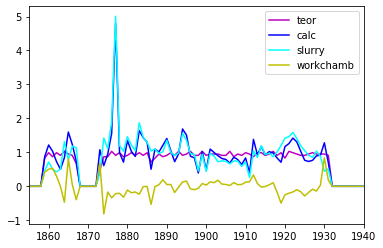

In [11]:
plt.figure()
(dfxls['dvol_teor[m³]']*dfxls['state2']).plot(c='m',label='teor')
(dfxls['dvol_calc[m³]']*dfxls['state2']).plot(c='b',label='calc')
(dfxls['dvol_bal_feed_slurry[m³]']*dfxls['state2']).plot(c='cyan',label='slurry')
(dfxls['dvol_work_chamb[m³]']*dfxls['state2']).plot(c='y',label='workchamb')

plt.xlim(1855,1940)
plt.legend()

In [12]:
dfreduced=dfxls.loc[:,[col_list[pos_num],col_list[pos_feed],col_list[pos_slurry],col_list[pos_filllev],'dvol_bal_feed_slurry[m³]','dvol_work_chamb[m³]','dvol_teor[m³]','dvol_calc[m³]','dvol_teor-calc[m³]']]

In [13]:
dfreduced.groupby(col_list[pos_num]).agg(np.average)

,Flow feed line [m³/h],Flow slurry line [m³/h],Fill level working chamber [m],dvol_bal_feed_slurry[m³],dvol_work_chamb[m³],dvol_teor[m³],dvol_calc[m³],dvol_teor-calc[m³]
S-1048_ADVANCE_ADVANCE_NO [-],,,,,,,,
4201,445.576182,485.967922,0.600130,0.336598,0.019335,0.288265,0.355933,-0.067668
4202,937.706839,997.494151,0.599995,0.498228,-0.004388,0.365589,0.493839,-0.128250
4203,896.246789,945.491432,0.564637,0.410372,0.011195,0.328389,0.421568,-0.093179
4204,273.703806,294.288308,0.523942,0.171538,-0.007851,0.142503,0.163687,-0.021184
4205,119.339317,129.672903,0.550027,0.086113,0.000219,0.074508,0.086333,-0.011824
4206,274.896902,297.759495,0.416213,0.190522,0.000260,0.150120,0.190781,-0.040661
4207,73.510305,74.056947,0.509025,0.004555,-0.001086,0.000000,0.003470,-0.003470


In [14]:
dfxls.loc[:,[col_list[pos_num],col_list[pos_feed],col_list[pos_slurry],col_list[pos_filllev],'dvol_bal_feed_slurry[m³]','dvol_work_chamb[m³]','dvol_teor[m³]','dvol_calc[m³]','dvol_teor-calc[m³]']]

,S-1048_ADVANCE_ADVANCE_NO [-],Flow feed line [m³/h],Flow slurry line [m³/h],Fill level working chamber [m],dvol_bal_feed_slurry[m³],dvol_work_chamb[m³],dvol_teor[m³],dvol_calc[m³],dvol_teor-calc[m³]
0,4201,0.000,0.0,0.159,0.0000,0.00000,0.0,0.00000,0.00000
1,4201,0.072,0.0,0.157,-0.0006,-0.01124,0.0,-0.01184,0.01184
2,4201,0.072,0.0,0.157,-0.0006,0.00000,0.0,-0.00060,0.00060
3,4201,0.000,0.0,0.157,0.0000,0.00000,0.0,0.00000,0.00000
4,4201,0.000,0.0,0.157,0.0000,0.00000,0.0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...
2875,4207,0.000,0.0,0.472,0.0000,0.00000,0.0,0.00000,0.00000
2876,4207,0.000,0.0,0.471,0.0000,-0.00590,0.0,-0.00590,0.00590
2877,4207,0.000,0.0,0.471,0.0000,0.00000,0.0,0.00000,0.00000
2878,4207,0.000,0.0,0.471,0.0000,0.00000,0.0,0.00000,0.00000


In [15]:
## plot "change2" that detect jump from activity to stop

dfxls[dfxls['change2']==True][[col_list[pos_stroke],col_list[pos_num],'change2','change']]

,AET Net Stroke [mm],S-1048_ADVANCE_ADVANCE_NO [-],change2,change
199,1587,4202,True,False
369,1612,4202,True,False
566,1588,4203,True,False
962,1618,4205,True,False
1868,214,4205,True,False
1932,1601,4205,True,False
2349,1601,4206,True,False


In [16]:
## Plot "change" that detect starts of activity

dfxls[dfxls['change']==True].groupby(col_list[pos_num]).agg({col_list[pos_stroke]:min})

,AET Net Stroke [mm]
S-1048_ADVANCE_ADVANCE_NO [-],
4201,38
4202,38
4203,38
4204,25
4205,29
4206,40


S-1048_ADVANCE_ADVANCE_NO [-]
4201    AxesSubplot(0.125,0.125;0.775x0.755)
4202    AxesSubplot(0.125,0.125;0.775x0.755)
4203    AxesSubplot(0.125,0.125;0.775x0.755)
4204    AxesSubplot(0.125,0.125;0.775x0.755)
4205    AxesSubplot(0.125,0.125;0.775x0.755)
4206    AxesSubplot(0.125,0.125;0.775x0.755)
4207    AxesSubplot(0.125,0.125;0.775x0.755)
Name: AET Net Stroke [mm], dtype: object

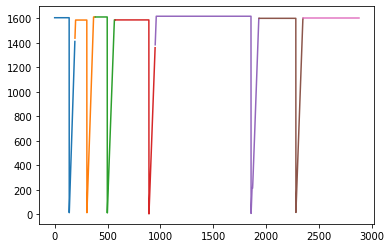

In [17]:
dfxls.groupby(col_list[pos_num])[col_list[pos_stroke]].plot()

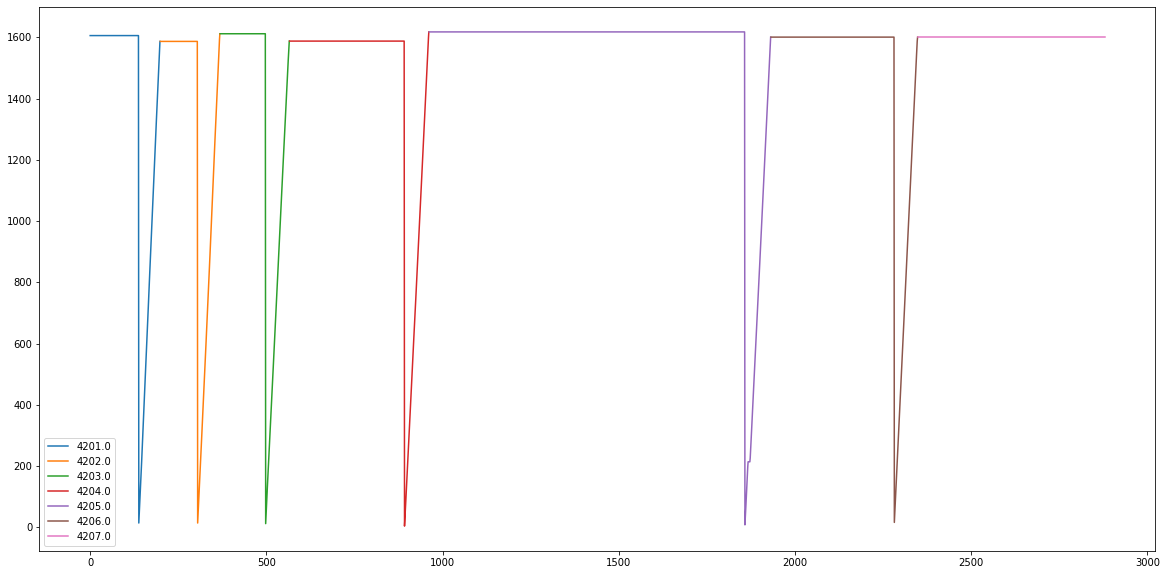

In [18]:
plt.figure(figsize=(20,10))
dfxls.groupby('num_corr')[col_list[pos_stroke]].plot()
plt.legend()

In [19]:
# prima metti a posto il numero di anello

In [20]:
# used_g = df.groupby('user')['used']
# df['new'] = used_g.cumcount() - used_g.transform(lambda x: (x.values).argmax())

num_corr
4201.0    AxesSubplot(0.125,0.125;0.775x0.755)
4202.0    AxesSubplot(0.125,0.125;0.775x0.755)
4203.0    AxesSubplot(0.125,0.125;0.775x0.755)
4204.0    AxesSubplot(0.125,0.125;0.775x0.755)
4205.0    AxesSubplot(0.125,0.125;0.775x0.755)
4206.0    AxesSubplot(0.125,0.125;0.775x0.755)
4207.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dvol_bal_feed_slurry_cum_seg[m³], dtype: object

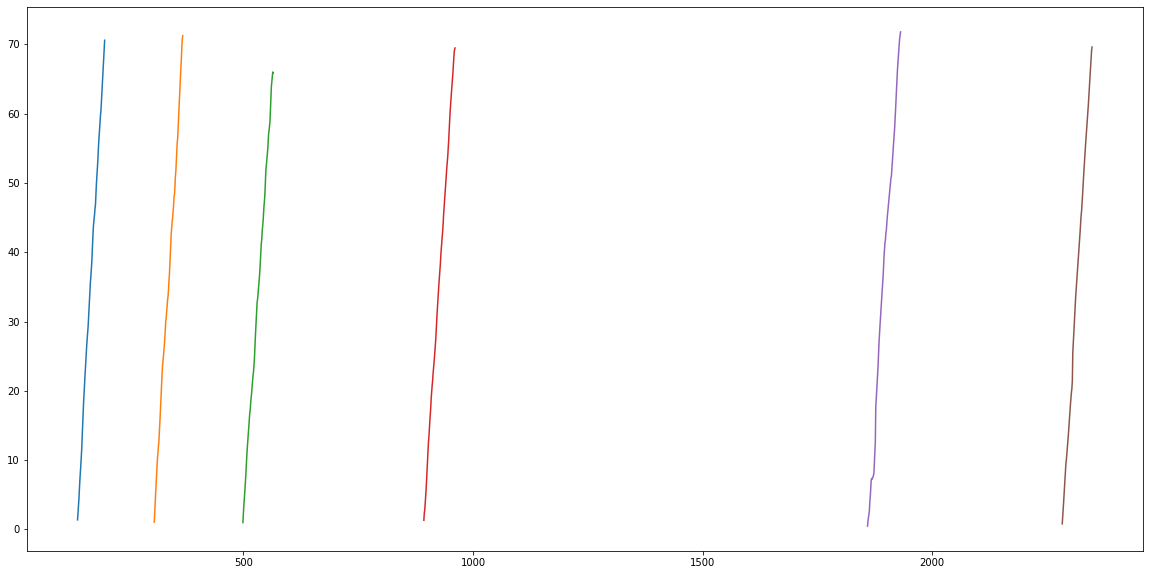

In [21]:
plt.figure(figsize=(20,10))
dfxls.groupby('num_corr')['dvol_bal_feed_slurry_cum_seg[m³]'].plot()

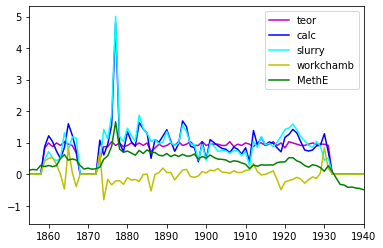

In [22]:
plt.figure()
(dfxls['dvol_teor[m³]']*dfxls['state2']).plot(c='m',label='teor')
(dfxls['dvol_calc[m³]']*dfxls['state2']).plot(c='b',label='calc')
(dfxls['dvol_bal_feed_slurry[m³]']*dfxls['state2']).plot(c='cyan',label='slurry')
(dfxls['dvol_work_chamb[m³]']*dfxls['state2']).plot(c='y',label='workchamb')
(dfxls['dvol_calc_MthE[m³]']).plot(c='g',label='MethE')
plt.xlim(1855,1940)
plt.legend()

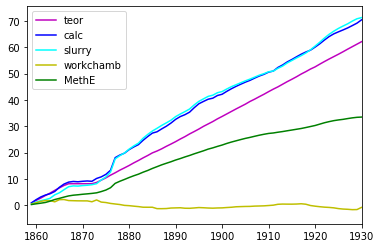

In [23]:
plt.figure()
(dfxls['dvol_teor_cum_seg[m³]']).plot(c='m',label='teor')
(dfxls['dvol_calc_cum_seg[m³]']).plot(c='b',label='calc')
(dfxls['dvol_bal_feed_slurry_cum_seg[m³]']).plot(c='cyan',label='slurry')
(dfxls['dvol_work_chamb_cum_seg[m³]']).plot(c='y',label='workchamb')
(dfxls['dvol_calc_MthE_cum_seg[m³]']).plot(c='g',label='MethE')
plt.xlim(1858,1930)
plt.legend()

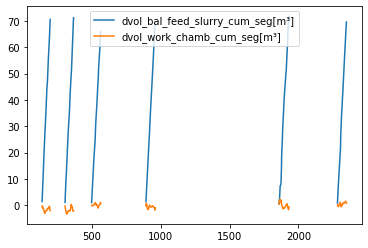

In [24]:
# 'vol_teor_cum[m³]'
# #
# 'dvol_teor[m³]'
# 'dvol_bal_feed_slurry[m³]'    
# 'dvol_work_chamb[m³]'
# #
# 'dvol_calc[m³]'
# 'dvol_teor-calc[m³]'


# dfxls['dvol_teor_cum_seg[m³]'].plot()
dfxls['dvol_bal_feed_slurry_cum_seg[m³]'].plot()
dfxls['dvol_work_chamb_cum_seg[m³]'].plot()
# dfxls['dvol_calc_cum_seg[m³]'].plot()
# dfxls['dvol_teor-calc_cum_seg[m³]'].plot()

plt.legend()

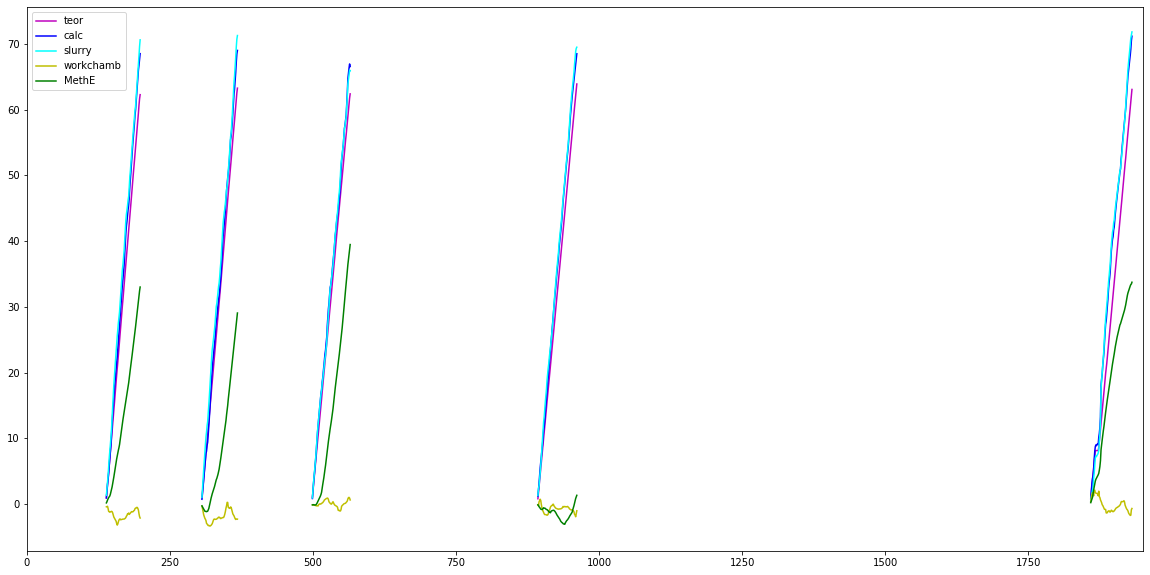

In [25]:
plt.figure(figsize=(20,10))
(dfxls['dvol_teor_cum_seg[m³]']).plot(c='m',label='teor')
(dfxls['dvol_calc_cum_seg[m³]']).plot(c='b',label='calc')
(dfxls['dvol_bal_feed_slurry_cum_seg[m³]']).plot(c='cyan',label='slurry')
(dfxls['dvol_work_chamb_cum_seg[m³]']).plot(c='y',label='workchamb')
(dfxls['dvol_calc_MthE_cum_seg[m³]']).plot(c='g',label='MethE')
# plt.xlim(1858,1930)
plt.xlim(0,1950)
plt.legend()

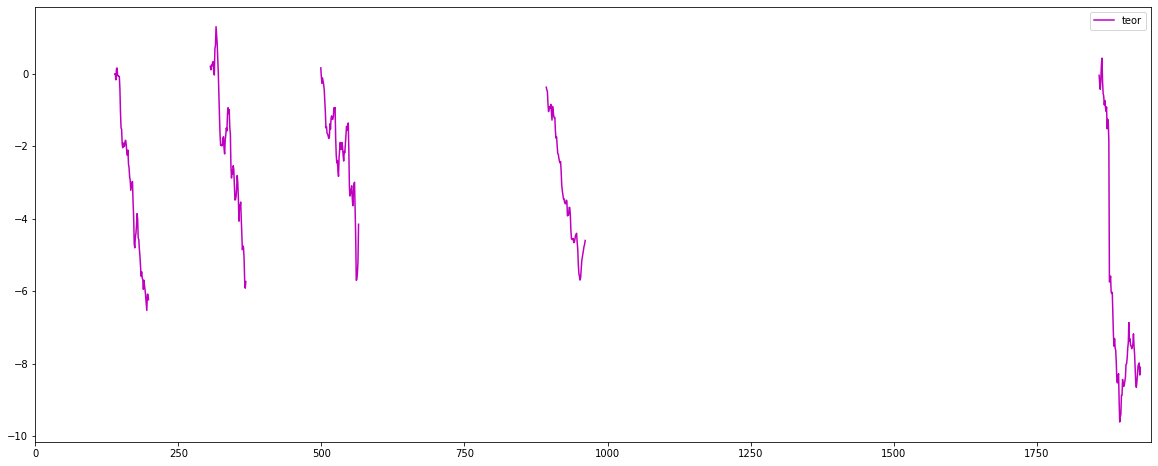

In [26]:
plt.figure(figsize=(20,8))
dfxls['dvol_teor-calc_cum_seg[m³]'].plot(c='m',label='teor')
# plt.xlim(1858,1930)
plt.xlim(0,1950)
plt.legend()

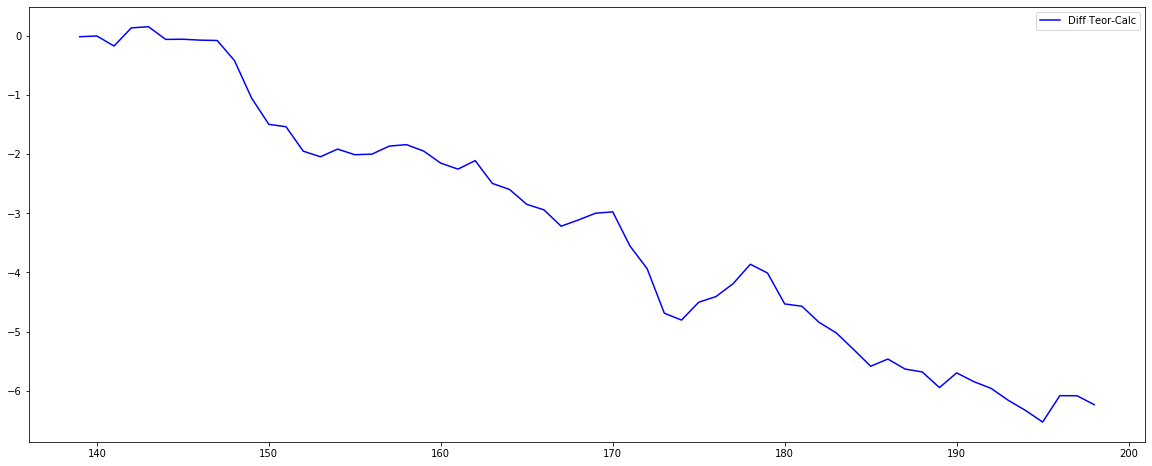

In [27]:
plt.figure(figsize=(20,8))
dfxls[dfxls['num_corr']==4201]['dvol_teor-calc_cum_seg[m³]'].plot(c='b', label='Diff Teor-Calc')
plt.legend()

In [211]:
col_list_print = [cl[pos_stroke],cl[pos_advspeed],'dstroke_pos[mm]','dstroke_pos_cum_seg[mm]','num_corr','change','change2','state','state1','state2','state3',cl[pos_filllev],cl[pos_feed],cl[pos_slurry],'vol_teor_cum[m³]','dvol_teor[m³]','dvol_teor_dry[m³]','bal_feed_slurry[m³/h]','dvol_bal_feed_slurry[m³]','dvol_work_chamb[m³]','dvol_calc[m³]','dvol_calc_cum_seg[m³]','dvol_calc_MthE[m³]','dvol_teor_cum_seg[m³]','dvol_calc_MthE_cum_seg[m³]','dvol_teor-calc[m³]']
# col_list_print =  [cl[pos_stroke], 'vol_teor_cum[m³]','dvol_teor[m³]']

# col_list_print = ['state3','num_corr','theormass1','dtheormass2','theormass2']

# dfpar = dfxls[1859:1932][col_list_print]

col_list_print = ['num_corr','state3','metha1','metha2','metha3','metha']


dfpar = dfxls[dfxls.num_corr==4205][dfxls.state3==1][col_list_print]

dfpar = dfxls[1857:1934][col_list_print]

# dfpar.to_excel('dfpar_4205.xls')

dfpar

,num_corr,state3,metha1,metha2,metha3,metha
1857,4205.0,0,305.085220,351.769824,NaN,NaN
1858,4205.0,0,276.264619,358.869706,NaN,NaN
1859,4205.0,1,306.800797,380.129058,0.611069,0.611069
1860,4205.0,1,297.675393,379.084688,0.678411,1.289480
1861,4205.0,1,305.923202,378.973255,0.608750,1.898230
...,...,...,...,...,...,...
1929,4205.0,1,371.802327,439.665179,0.565524,78.234419
1930,4205.0,1,372.030382,410.758519,0.322734,78.557154
1931,4205.0,1,368.423741,450.993071,0.688078,79.245231
1932,4206.0,0,359.156450,395.166148,NaN,NaN


In [29]:
# 'vol_teor_cum[m³]'  DO NOT USE
# 'vol_teor_cum_dry[m³]' DO NOT USE

# 'dstroke_pos_cum_seg[mm]'
# 'dvol_teor[m³]'
# 'dvol_teor_dry[m³]'
# 'dvol_bal_feed_slurry[m³]'      feed-slurry
# 'dvol_work_chamb[m³]'           fill
# 'dvol_calc[m³]'                 dvol_bal_feed_slurry + dvol_work_chamb
# 'dvol_calc_MthE[m³]'
# 'dvol_teor-calc[m³]'
# 'dvol_teor_cum_seg[m³]'
# 'dvol_bal_feed_slurry_cum_seg[m³]'
# 'dvol_work_chamb_cum_seg[m³]'
# 'dvol_calc_cum_seg[m³]'
# 'dvol_teor-calc_cum_seg[m³]'
# 'dvol_calc_MthE_cum_seg[m³]'

In [259]:
dfxls

,Date,S-1048_ADVANCE_ADVANCE_NO [-],Pressure excavation chamber 1 [bar],Pressure excavation chamber 2 [bar],Pressure excavation chamber 3 [bar],Pressure excavation chamber 4 [bar],Pressure excavation chamber 5 [bar],Pressure excavation chamber 6 [bar],Pressure excavation chamber 7 [bar],Pressure excavation chamber 8 [bar],Line 1 grout injection pressure [bar],Line 1 grout injection flow [l/min],Line 1 grout injection amount [l],Line 2 grout injection pressure [bar],Line 2 grout injection flow [l/min],Line 2 grout injection amount [l],Line 3 grout injection pressure [bar],Line 3 grout injection flow [l/min],Line 3 grout injection amount [l],Line 4 grout injection pressure [bar],Line 4 grout injection flow [l/min],Line 4 grout injection amount [l],Grout injection quantity calculated in m3 [m³],Grout injection total quantity in m3 [m³],Total amount of component A [l],Total amount of component B [l],Total advance force [kN],Advance speed [mm/min],Penetration [mm/rot],Torque cutting wheel [MNm],Contact force shield articulation [kN],Specific energy MJ/m3 [MJ/m³],Fill level working chamber [m],Excavated bentonite [m³],Air Flow in Normal m3/min [m³/min],AET Mass [t],AET Volume [m³],FS0011 Pressure transducer screw conveyor pump 1 high pressure [bar],FS0012 Pressure transducer screw conveyor pump 1 feed pressure [bar],Screw Conveyor Front Pressure [bar],Screw Conveyor Rear Pressure [bar],Screw gate front open [Bit],Screw gate front closed [Bit],Screw gate 1 rear open [Bit],Screw gate 1 rear closed [Bit],Speed screw conveyor from gear sensor [rpm],Torque screw conveyor calculated [-],Slurry circuit P04 density [t/m³],Density feed line [t/m³],Density slurry line [t/m³],Flow feed line [m³/h],Flow slurry line [m³/h],P0.1 feed pump operation [Bit],P0.1 delivery pressure [bar],P0.1 suction pressure [bar],P0.1 Flow [m³/h],P0.2 feed pump operation [Bit],P0.2 delivery pressure [bar],P0.2 suction pressure [bar],P0.2 Flow [m³/h],P0.3 feed pump operation [Bit],P0.3 delivery pressure [bar],P0.3 suction pressure [bar],P0.3 Flow [m³/h],P0.4 feed pump operation [Bit],P0.4 delivery pressure [bar],P0.4 suction pressure [bar],P0.4 Flow [m³/h],P1.1 feed pump operation [Bit],P1.1 delivery pressure [bar],P1.1 suction pressure [bar],P1.2 feed pump operation [Bit],P1.2 delivery pressure [bar],P1.2 suction pressure [bar],P2.1 feed pump operation [Bit],P2.1 delivery pressure [bar],P2.1 suction pressure [bar],P2.2 feed pump operation [Bit],P2.2 delivery pressure [bar],P2.2 suction pressure [bar],P2.3 feed pump operation [Bit],P2.3 delivery pressure [bar],P2.3 suction pressure [bar],P2.4 feed pump operation [Bit],P2.4 delivery pressure [bar],P2.4 suction pressure [bar],P2.5 feed pump operation [Bit],P2.5 delivery pressure [bar],P2.5 suction pressure [bar],P2.6 feed pump operation [Bit],P2.6 delivery pressure [bar],P2.6 suction pressure [bar],P2.7 feed pump operation [Bit],P2.7 delivery pressure [bar],P2.7 suction pressure [bar],P3.8 delivery pressure [bar],P3.8 pump operation [Bit],P0.5 flow [m³/h],"Slurry Circuit Flow Sensor, Position 2 [m³/h]","Slurry Circuit Flow Sensor, Position 3 [m³/h]","Slurry Circuit Flow Sensor, Position 4 [m³/h]","Slurry Circuit Flow Sensor, Position 5 [m³/h]","Slurry Circuit Flow Sensor, Position 6 [m³/h]","Slurry Circuit Flow Sensor, Position 7 [m³/h]","Slurry Circuit Flow Sensor, Position 8 [m³/h]",AET Net Stroke [mm],Stroke thrust cylinder Gr. A [mm],Stroke thrust cylinder Gr. B [mm],Stroke thrust cylinder Gr. C [mm],Stroke thrust cylinder Gr. D [mm],Stroke thrust cylinder Gr. E [mm],datestamp,timestamp,datestamp_p,datestamp_diff,datestamp_diff[h],dt_h,dpress_ch1,dpress_ch2,dpress_ch3,dpress_ch4,dpress_ch5,dpress_ch6,dpress_ch7,dpress_ch8,stroke_diff[mm],stroke_diff_a[mm],stroke_diff_b[mm],stroke_diff_c[mm],stroke_diff_d[mm],stroke_diff_e[mm],state1,dstroke[mm],state2,dstroke_pos[mm],nw,vol_teor_cum[m³],vol_teor_cum_dry[m³],dvol_teor[m³],dvol_teor_dry[m³],bal_feed_slurry[m³/h],dvol_bal_feed_slurry[m³],dvol_bal_feed_slurry_cum[m³],r

In [299]:
dfxls = pd.read_hdf('ALL2.h5', key='losses')

In [305]:
dfxls

,AETMass[t],AETVolume[m³],Advancespeed[mm/min],AirFlowinNormalm3/min[m³/min],Contactforceshieldarticulation[kN],Date,Densityfeedline[t/m³],Densityslurryline[t/m³],Excavatedbentonite[m³],FS0011_Pres_transducerscrewconvpump1high_pres_[bar],FS0012_Pres_transducerscrewconvpump1feed_pres_[bar],Filllevelworkingchamber[m],Flowfeedline[m³/h],Flowslurryline[m³/h],Groutinjectionquantitycalculatedinm3[m³],Groutinjectiontotalquantityinm3[m³],Line1groutinjectionamount[l],Line1groutinjectionflow[l/min],Line1groutinjection_pres_[bar],Line2groutinjectionamount[l],Line2groutinjectionflow[l/min],Line2groutinjection_pres_[bar],Line3groutinjectionamount[l],Line3groutinjectionflow[l/min],Line3groutinjection_pres_[bar],Line4groutinjectionamount[l],Line4groutinjectionflow[l/min],Line4groutinjection_pres_[bar],P0.1Flow[m³/h],P0.1delivery_pres_[bar],P0.1feedpumpoperation[Bit],P0.1suction_pres_[bar],P0.2Flow[m³/h],P0.2delivery_pres_[bar],P0.2feedpumpoperation[Bit],P0.2suction_pres_[bar],P0.3Flow[m³/h],P0.3delivery_pres_[bar],P0.3feedpumpoperation[Bit],P0.3suction_pres_[bar],P0.4Flow[m³/h],P0.4delivery_pres_[bar],P0.4feedpumpoperation[Bit],P0.4suction_pres_[bar],P1.1delivery_pres_[bar],P1.1feedpumpoperation[Bit],P1.1suction_pres_[bar],P1.2delivery_pres_[bar],P1.2feedpumpoperation[Bit],P1.2suction_pres_[bar],P2.1delivery_pres_[bar],P2.1feedpumpoperation[Bit],P2.1suction_pres_[bar],P2.2delivery_pres_[bar],P2.2feedpumpoperation[Bit],P2.2suction_pres_[bar],P2.3delivery_pres_[bar],P2.3feedpumpoperation[Bit],P2.3suction_pres_[bar],P2.4delivery_pres_[bar],P2.4feedpumpoperation[Bit],P2.4suction_pres_[bar],P2.5delivery_pres_[bar],P2.5feedpumpoperation[Bit],P2.5suction_pres_[bar],P2.6delivery_pres_[bar],P2.6feedpumpoperation[Bit],P2.6suction_pres_[bar],P2.7delivery_pres_[bar],P2.7feedpumpoperation[Bit],P2.7suction_pres_[bar],P3.8delivery_pres_[bar],P3.8pumpoperation[Bit],Penetration[mm/rot],_Pres_excavationchamber1[bar],_Pres_excavationchamber2[bar],_Pres_excavationchamber3[bar],_Pres_excavationchamber4[bar],_Pres_excavationchamber5[bar],_Pres_excavationchamber6[bar],_Pres_excavationchamber7[bar],_Pres_excavationchamber8[bar],S-1048_ADVANCE_ADVANCE_NO[-],ScrewConveyorFront_Pres_[bar],ScrewConveyorRear_Pres_[bar],Screwgate1rearclosed[Bit],Screwgate1rearopen[Bit],Screwgatefrontclosed[Bit],Screwgatefrontopen[Bit],SlurrycircuitP04density[t/m³],SpecificenergyMJ/m3[MJ/m³],Speedscrewconvfromgearsensor[rpm],Torquecuttingwheel[MNm],Torquescrewconvcalculated[-],Totaladvanceforce[kN],TotalamountofcomponentA[l],TotalamountofcomponentB[l]
4098490,68.640,97.697,24,0.09,15075,2018-12-08 15:41:40,1.000,1.000,1242,95.218,15.469,-0.170,929.109,1030.020,0.0,6267,1606.1,25,3.021,1458.6,25,4.492,1261.7,21,2.686,1592.5,25,3.003,211.090,3.195,1,1.965,243.123,2.520,1,1.871,0.000,0.078,0,0.0,85.879,2.242,1,1.219,3.083,1,-0.458,-1.000,0.0,-1.000,4.406,1,1.316,-1,0.0,-1,-1,0.0,-1,-1.000,0.0,-1.000,6.473,1,1.789,5.637,1,1.293,5.207,1,2.531,4.102,0.0,12.0,1.778,1.935,2.048,2.171,2.237,2.202,1.805,1.677,2256.0,2.013,1.800,0,1,0,1,1.000,24,14.7,2.48,42,17250,5918.9,347.8
4098491,68.897,98.005,25,0.07,15024,2018-12-08 15:41:50,1.000,1.000,1245,90.432,15.352,-0.175,910.807,1036.892,0.0,6287,1611.2,25,3.027,1463.6,25,4.486,1266.0,21,2.686,1597.6,25,3.003,210.895,3.145,1,1.910,242.830,2.383,1,1.852,0.000,0.078,0,0.0,86.196,2.203,1,1.160,3.120,1,-0.459,-1.000,0.0,-1.000,4.211,1,1.254,-1,0.0,-1,-1,0.0,-1,-1.000,0.0,-1.000,6.317,1,1.645,5.762,1,1.238,5.117,1,2.406,4.106,0.0,13.0,1.746,1.906,2.019,2.149,2.244,2.093,1.780,1.647,2256.0,1.986,1.607,0,1,0,1,1.000,25,14.8,2.63,40,17087,5938.3,348.9
4098492,69.120,98.311,26,0.07,14971,2018-12-08 15:42:00,1.000,1.000,1248,91.409,15.396,-0.179,907.624,1036.748,0.0,6304,1615.3,25,3.021,1467.6,25,4.474,1269.4,21,2.686,1601.6,25,2.973,210.211,3.082,1,1.891,236.775,2.367,1,1.832,0.000,0.078,0,0.0,82.925,2.207,1,1.274,3.120,1,-0.461,-1.000,0.0,-1.000,4.356,1,1.277,-1,0.0,-1,-1,0.0,-1,-1.000,0.0,-1.000,6.492,1,1.645,5.735,1,1.238,5.129,1,2.504,4.113,0.0,13.0,1.756,

In [304]:
dfxls['Groutinjectionquantitycalculatedinm3[m³]']

AttributeError: 'Series' object has no attribute 'describecribe'